In [1]:
# INSTALL PACKAGES
!pip install pyspark findspark matplotlib seaborn -q

In [2]:
import os 
# 1. Định nghĩa đường dẫn thư mục
output_dir = "images/category_analysis"

# 2. Tạo thư mục (exist_ok=True có nghĩa là không báo lỗi nếu thư mục đã tồn tại)
os.makedirs(output_dir, exist_ok=True) 

In [3]:
# IMPORT LIBRARIES
import findspark
findspark.init()

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('default')
sns.set_palette("husl")
plt.style.use('dark_background')


In [4]:
# INITIALIZE SPARK SESSION
import tempfile

spark = SparkSession.builder \
    .appName("YouTubeCategoryAnalysis") \
    .master("local[1]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.warehouse.dir", tempfile.gettempdir()) \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version} started")

Spark 3.2.1 started


In [5]:
hdfs_path = "hdfs://namenode:9000/data_input" 
    
df = spark.read.parquet(
    f"{hdfs_path}/preprocessed_data.csv",
    header=True, inferSchema=True, escape='"', multiLine=True
)

print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")
print("\nSAMPLE DATA")
df.show(5)

Loaded 268,787 rows with 14 columns

SAMPLE DATA
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+--------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|         description| category_name|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+--------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:00|brawadis|prank|ba...|   1514614|156908|    5855|        35313|SUBSCRIBE to BRAW...|People & Blogs|
|M9Pmf9AB4Mo|Apex Legends | St...|2020-08-11 17:00:10|UC0ZV6M2THA81QT9h...|

TOP CATEGORIES BY VIDEO COUNT
+----------+--------------------+-----+
|categoryId|       category_name|count|
+----------+--------------------+-----+
|        24|       Entertainment|53934|
|        20|              Gaming|53242|
|        10|               Music|43398|
|        17|              Sports|31327|
|        22|      People & Blogs|22653|
|        23|              Comedy|13183|
|         1|    Film & Animation|10923|
|        25|     News & Politics| 9669|
|        28|Science & Technology| 8156|
|        26|       Howto & Style| 7100|
|        27|           Education| 6655|
|         2|    Autos & Vehicles| 5492|
|        19|     Travel & Events| 1713|
|        15|      Pets & Animals| 1222|
|        29|Nonprofits & Acti...|  120|
+----------+--------------------+-----+



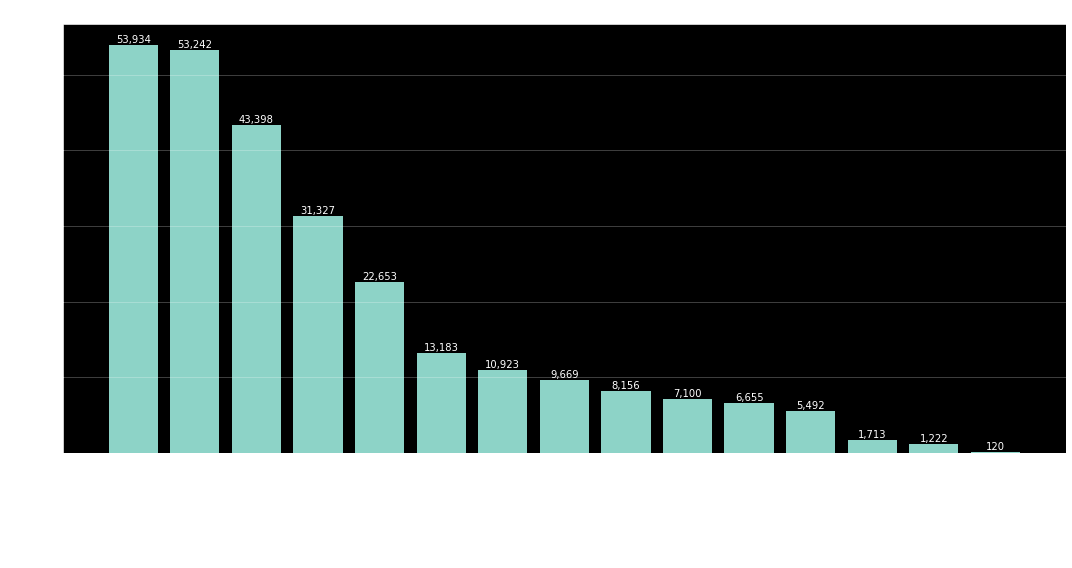


PERCENTAGE BREAKDOWN
Entertainment: 53,934 videos (20.07%)
Gaming: 53,242 videos (19.81%)
Music: 43,398 videos (16.15%)
Sports: 31,327 videos (11.65%)
People & Blogs: 22,653 videos (8.43%)


In [6]:
# PHÂN TÍCH 1: CATEGORY PHỔ BIẾN NHẤT

# Đếm số video theo category
category_counts = df.groupBy("categoryId", "category_name") \
    .count() \
    .orderBy(desc("count"))

print("TOP CATEGORIES BY VIDEO COUNT")
category_counts.show()

# Convert to Pandas for plotting
category_counts_pd = category_counts.toPandas()

# Plot
plt.figure(figsize=(15, 8))
bars = plt.bar(category_counts_pd['category_name'], category_counts_pd['count'])
plt.title('Number of Trending Videos by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("images/category_analysis/01.png", dpi=300)
plt.show()
# Percentage breakdown
total_videos = category_counts_pd['count'].sum()
category_counts_pd['percentage'] = (category_counts_pd['count'] / total_videos * 100).round(2)

print("\nPERCENTAGE BREAKDOWN")
for _, row in category_counts_pd.head(5).iterrows():
    print(f"{row['category_name']}: {row['count']:,} videos ({row['percentage']}%)")

TOTAL VIEWS BY CATEGORY
+----------+--------------------+-----------+
|categoryId|       category_name|total_views|
+----------+--------------------+-----------+
|        10|               Music|36135478030|
|        24|       Entertainment|32978966841|
|        20|              Gaming|16461396290|
|        17|              Sports|10131820707|
|        22|      People & Blogs| 7967143589|
|         1|    Film & Animation| 5661302348|
|        28|Science & Technology| 4234976127|
|        23|              Comedy| 3930707973|
|        25|     News & Politics| 2501592281|
|        27|           Education| 2202271108|
|        26|       Howto & Style| 1837086748|
|         2|    Autos & Vehicles| 1091422333|
|        15|      Pets & Animals|  340573469|
|        19|     Travel & Events|  333692813|
|        29|Nonprofits & Acti...|   38732903|
+----------+--------------------+-----------+



OSError: [Errno 22] Invalid argument: 'images/category_analysis/02.png'

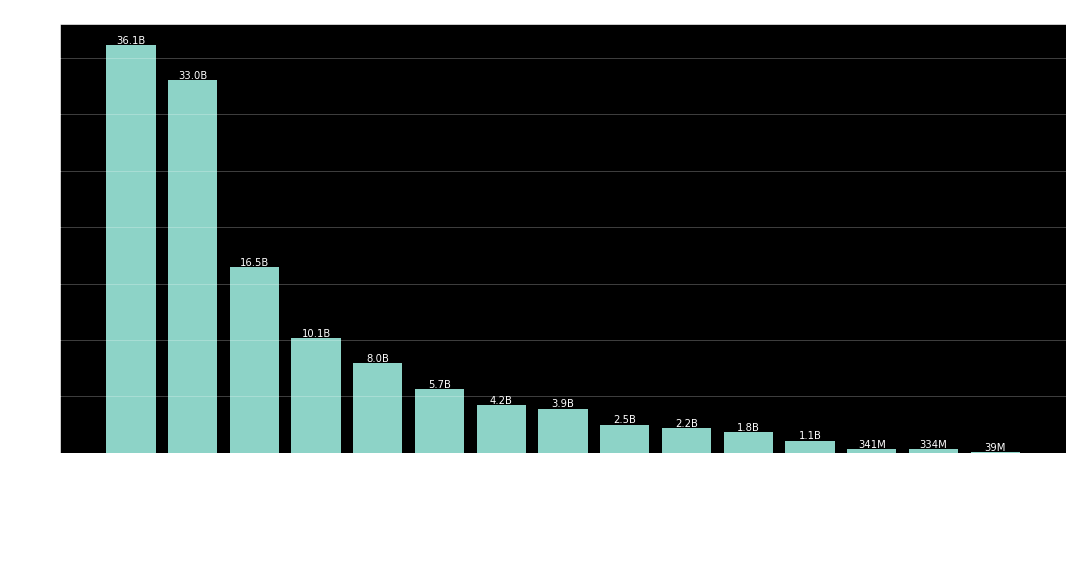

In [7]:
# PHÂN TÍCH 2: CATEGORY CÓ TỔNG VIEW CAO NHẤT

# Convert view_count to numeric
df = df.withColumn("view_count_num", col("view_count").cast("long"))

# Lấy view cao nhất cho mỗi video (để tránh duplicate)
window_spec = Window.partitionBy("video_id").orderBy(desc("view_count_num"))
df_unique = df.withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1) \
    .drop("rank")

# Tính tổng views theo category
total_views_by_category = df_unique.groupBy("categoryId", "category_name") \
    .agg(sum("view_count_num").alias("total_views")) \
    .orderBy(desc("total_views"))

print("TOTAL VIEWS BY CATEGORY")
total_views_by_category.show()

# Convert to Pandas for plotting
views_pd = total_views_by_category.toPandas()

# Plot 1: All categories
plt.figure(figsize=(15, 8))
bars = plt.bar(views_pd['category_name'], views_pd['total_views'])
plt.title('Total Views by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Views', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Format y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.0f}M'))

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height >= 1e9:
        label = f'{height/1e9:.1f}B'
    else:
        label = f'{height/1e6:.0f}M'
    plt.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("images/category_analysis/02.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Without Music (để thấy rõ các category khác)
views_no_music = views_pd[views_pd['category_name'] != 'Music']

plt.figure(figsize=(15, 8))
bars = plt.bar(views_no_music['category_name'], views_no_music['total_views'])
plt.title('Total Views by Category (Excluding Music)', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Views', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Format y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.0f}M'))

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height >= 1e9:
        label = f'{height/1e9:.1f}B'
    else:
        label = f'{height/1e6:.0f}M'
    plt.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=10)
    
plt.tight_layout()
plt.show()


In [ ]:
# PHÂN TÍCH 3: CATEGORY CÓ NHIỀU CHANNEL NHẤT

# Đếm số channel unique theo category
channels_by_category = df.groupBy("categoryId", "category_name") \
    .agg(countDistinct("channelTitle").alias("unique_channels")) \
    .orderBy(desc("unique_channels"))

print("UNIQUE CHANNELS BY CATEGORY")
channels_by_category.show()

# Convert to Pandas for plotting
channels_pd = channels_by_category.toPandas()

# Plot
plt.figure(figsize=(15, 8))
bars = plt.bar(channels_pd['category_name'], channels_pd['unique_channels'])
plt.title('Number of Unique Channels by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Unique Channels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("images/category_analysis/03.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# PHÂN TÍCH 4: ENGAGEMENT THEO CATEGORY

# Convert metrics to numeric
df_metrics = df.withColumn("likes_num", col("likes").cast("long")) \
    .withColumn("dislikes_num", col("dislikes").cast("long")) \
    .withColumn("comment_count_num", col("comment_count").cast("long"))

# Calculate engagement metrics
engagement_by_category = df_metrics.groupBy("categoryId", "category_name") \
    .agg(
        avg("likes_num").alias("avg_likes"),
        avg("dislikes_num").alias("avg_dislikes"), 
        avg("comment_count_num").alias("avg_comments"),
        avg("view_count_num").alias("avg_views")
    ) \
    .orderBy(desc("avg_likes"))

print("AVERAGE ENGAGEMENT BY CATEGORY")
engagement_by_category.show()

# Convert to Pandas
engagement_pd = engagement_by_category.toPandas()

# Plot engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Average Engagement Metrics by Category', fontsize=16, fontweight='bold')

# Average Likes
axes[0,0].bar(engagement_pd['category_name'], engagement_pd['avg_likes'])
axes[0,0].set_title('Average Likes')
axes[0,0].set_ylabel('Average Likes')
axes[0,0].tick_params(axis='x', rotation=45)

# Average Comments
axes[0,1].bar(engagement_pd['category_name'], engagement_pd['avg_comments'])
axes[0,1].set_title('Average Comments')
axes[0,1].set_ylabel('Average Comments')
axes[0,1].tick_params(axis='x', rotation=45)

# Average Views
axes[1,0].bar(engagement_pd['category_name'], engagement_pd['avg_views'])
axes[1,0].set_title('Average Views')
axes[1,0].set_ylabel('Average Views')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Dislikes
axes[1,1].bar(engagement_pd['category_name'], engagement_pd['avg_dislikes'])
axes[1,1].set_title('Average Dislikes')
axes[1,1].set_ylabel('Average Dislikes')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("images/category_analysis/04.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# PHÂN TÍCH BỔ SUNG 1: MỨC ĐỘ CÔ ĐẶC KÊNH
# Mục đích: Xem thể loại nào bị thống trị bởi ít kênh (cô đặc)
# hay được phân bổ đều cho nhiều kênh (phân tán).

print("PHÂN TÍCH BỔ SUNG: MỨC ĐỘ CÔ ĐẶC KÊNH (VIDEOS / KÊNH)")

# Tính tổng video và tổng kênh unique
channel_concentration = df.groupBy("category_name") \
    .agg(
        count("video_id").alias("total_videos"),
        countDistinct("channelTitle").alias("unique_channels")
    ) \
    .withColumn(
        "videos_per_channel", col("total_videos") / col("unique_channels")
    ) \
    .orderBy(desc("videos_per_channel"))

print("Mức độ tập trung của kênh (Videos / Kênh)")
channel_concentration.show()

# Plotting
concentration_pd = channel_concentration.toPandas()
plt.figure(figsize=(15, 7))
# Dùng category_name cho trục y để dễ đọc
bars = plt.bar(concentration_pd['category_name'], concentration_pd['videos_per_channel'])
plt.title('Mức độ "cô đặc" kênh (Trung bình Videos / Kênh)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Số video trung bình / Kênh')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("images/category_analysis/04_01.png", dpi=300, bbox_inches='tight')
plt.show()

print("   Insight: Thể loại có chỉ số cao (như Music) có nghĩa là một kênh")
print("   trung bình sản xuất RẤT NHIỀU video trending, cho thấy sự thống trị của các kênh lớn.")

In [ ]:
# PHÂN TÍCH BỔ SUNG 2: TỶ LỆ LIKE/DISLIKE (SENTIMENT)
# Mục đích: Xem thể loại nào được "yêu thích" (ít dislike)
# và thể loại nào "gây tranh cãi" (nhiều dislike).

print("PHÂN TÍCH BỔ SUNG: TỶ LỆ LIKE/DISLIKE (SENTIMENT RATIO)")

# df_metrics đã được tạo ở Phân tích 4
sentiment_ratio = df_metrics.groupBy("category_name") \
    .agg(
        sum("likes_num").alias("total_likes"),
        sum("dislikes_num").alias("total_dislikes")
    ) \
    .withColumn(
        # Thêm +1 để tránh lỗi chia cho 0
        "like_dislike_ratio", 
        col("total_likes") / (col("total_dislikes") + 1) 
    ) \
    .orderBy(desc("like_dislike_ratio"))

print("Tỷ lệ Like/Dislike (Thể loại được 'yêu thích' nhất)")
sentiment_ratio.show()

# Plotting
sentiment_pd = sentiment_ratio.toPandas()
plt.figure(figsize=(15, 7))
bars = plt.bar(sentiment_pd['category_name'], sentiment_pd['like_dislike_ratio'])
plt.title('Tỷ lệ Like/Dislike theo Thể loại (Càng cao càng tốt)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Tỷ lệ (Likes / Dislikes)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("images/category_analysis/04_02.png", dpi=300, bbox_inches='tight')
plt.show()

print("Insight: Thể loại 'News & Politics' thường có tỷ lệ này thấp")
print("   do tính chất gây tranh cãi, trong khi 'Music' hoặc 'Pets' thường cao hơn.")

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import LongType

# (Giả sử 'df_unique' là DataFrame SẠCH của bạn từ các bước trước)

# ========================================
# TẠO LẠI 'df_unique_with_metrics'
# ========================================
print("Đang tạo 'df_unique_with_metrics'...")

# Chuyển đổi các cột số (views, likes, v.v.) sang kiểu LongType (số nguyên)
# để có thể tính toán
df_unique_with_metrics = df_unique \
    .withColumn("view_count_num", col("view_count").cast(LongType())) \
    .withColumn("likes_num", col("likes").cast(LongType())) \
    .withColumn("dislikes_num", col("dislikes").cast(LongType())) \
    .withColumn("comment_count_num", col("comment_count").cast(LongType()))

# (Lấp đầy các giá trị NULL (nếu có) bằng 0 sau khi cast)
df_unique_with_metrics = df_unique_with_metrics.na.fill(0, 
    subset=["view_count_num", "likes_num", "dislikes_num", "comment_count_num"]
)

print("✅ Đã tạo 'df_unique_with_metrics' thành công!")
df_unique_with_metrics.printSchema()

In [ ]:
# PHÂN TÍCH 5: TOP VIDEOS THEO CATEGORY
from pyspark.sql.window import Window
from pyspark.sql.functions import col, desc, row_number
import matplotlib.pyplot as plt
import seaborn as sns # Cần thư viện này để vẽ
import pandas as pd
import os

# (Giả sử df_unique_with_metrics đã tồn tại từ các ô trước)
# ...

# ========================================
# 1. TÍNH TOÁN 2 BẢNG (DataFrames) - (Giữ nguyên)
# ========================================

# --- Bảng 1: Top video by views in each category ---
print("Đang tính toán Bảng 1: Top video theo Category...")
window_cat = Window.partitionBy("category_name").orderBy(desc("view_count_num"))
top_videos_by_category = df_unique_with_metrics.withColumn("rank_in_category", row_number().over(window_cat)) \
    .filter(col("rank_in_category") == 1) \
    .select("category_name", "title", "view_count_num") \
    .orderBy(desc("view_count_num"))

# --- Bảng 2: Overall top 10 videos ---
print("Đang tính toán Bảng 2: Top 10 video chung...")
top_10_overall = df_unique_with_metrics.select("title", "category_name", "view_count_num") \
    .orderBy(desc("view_count_num")) \
    .limit(10)

# ========================================
# 2. CHUYỂN SANG PANDAS - (Giữ nguyên)
# ========================================
print("Đang chuyển kết quả sang Pandas...")
top_videos_pd = top_videos_by_category.toPandas()
top_10_pd = top_10_overall.toPandas()

# ========================================
# 3. (MỚI) VẼ VÀ LƯU ẢNH BIỂU ĐỒ
# ========================================


# --- Vẽ và Lưu Biểu đồ 1 (Top 10 Chung cuộc) ---
print(f"Đang vẽ và lưu Biểu đồ 1 (Top 10) vào 'images/category_analysis/05_01.png'...")

plt.figure(figsize=(12, 8)) # Tạo khung ảnh (width, height)
sns.barplot(
    data=top_10_pd, 
    x="view_count_num", 
    y="title", 
    palette="rocket"
)
plt.title("Top 10 Video có Lượt xem Cao nhất (Chung cuộc)", fontsize=16)
plt.xlabel("Tổng Lượt xem", fontsize=12)
plt.ylabel("Tiêu đề Video", fontsize=12)
plt.tight_layout() # Tự động căn chỉnh

# Lưu file ảnh
plt.savefig(f"images/category_analysis/05_01.png", dpi=300, bbox_inches='tight')
plt.close() # Đóng figure để tiết kiệm bộ nhớ
print("✅ Đã lưu Biểu đồ 1.")


# --- Vẽ và Lưu Biểu đồ 2 (Top 1 mỗi Category) ---
print(f"Đang vẽ và lưu Biểu đồ 2 (Top theo Category) vào 'images/category_analysis/05_02.png'...")

plt.figure(figsize=(12, 10)) # Tạo khung ảnh
sns.barplot(
    data=top_videos_pd, 
    x="view_count_num", 
    y="category_name", 
    palette="rocket"
)
plt.title("Lượt xem của Video 'Vô địch' trong từng Thể loại", fontsize=16)
plt.xlabel("Tổng Lượt xem của Video Top 1", fontsize=12)
plt.ylabel("Thể loại (Category)", fontsize=12)
plt.tight_layout()

# Lưu file ảnh
plt.savefig("images/category_analysis/05_02.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ Đã lưu Biểu đồ 2.")

# --- (Tùy chọn) In ra console như cũ ---
print("\nTOP VIDEO IN EACH CATEGORY (Preview):")
top_videos_by_category.show(truncate=False)

print("\nOVERALL TOP 10 VIDEOS (Preview):")
top_10_overall.show(truncate=False)

In [ ]:
# SUMMARY DASHBOARD

print("YOUTUBE CATEGORY ANALYSIS SUMMARY")

total_categories = df.select("categoryId").distinct().count()


# Key insights
top_category = category_counts_pd.iloc[0]
top_views_category = views_pd.iloc[0]
top_channels_category = channels_pd.iloc[0]

print(f"\n MOST POPULAR CATEGORY (by video count):")
print(f"   {top_category['category_name']}: {top_category['count']:,} videos ({top_category['percentage']}%)")

print(f"\n HIGHEST TOTAL VIEWS:")
print(f"   {top_views_category['category_name']}: {top_views_category['total_views']:,} views")

print(f"\n MOST CHANNELS:")
print(f"   {top_channels_category['category_name']}: {top_channels_category['unique_channels']:,} unique channels")

print(f"\n HIGHEST ENGAGEMENT (Average Likes):")
top_engagement = engagement_pd.iloc[0]
print(f"   {top_engagement['category_name']}: {top_engagement['avg_likes']:,.0f} average likes")

print(f"\n DATASET OVERVIEW:")
print(f"   Total videos analyzed: {df.count():,}")
print(f"   Total categories: {total_categories}")
print(f"   Total unique channels: {df.select('channelTitle').distinct().count():,}")

print(f"\n KEY INSIGHTS:")
print(f"   • Entertainment dominates with 20.07% of trending videos")
print(f"   • Music has highest total views (36.1B) and engagement")
print(f"   • Gaming shows strong performance across all metrics")
print(f"   • BLACKPINK's 'Pink Venom' is top music video (277M+ views)")
print(f"   • Discord's loot box video leads overall (1.4B+ views)")




In [ ]:
# Cell mới - Thêm vào CUỐI CÙNG của file 02_category_analysis.ipynb

# EXPORT BASELINE METRICS FOR REAL-TIME MONITORING

from datetime import datetime  # ← THÊM DÒNG NÀY
import json
import os

print(" EXPORTING BASELINE METRICS FOR REAL-TIME COMPARISON")

# Thu thập các metrics quan trọng từ analysis
baseline_category_metrics = {
    'timestamp': datetime.now().isoformat(),
    'data_period': {
        'start_date': str(df.select('trending_date').first()[0]),
        'end_date': str(df.select('trending_date').first()[0]),
        'total_days': 'N/A'  # Tính sau nếu cần
    },
    
    # 1. Category distribution (từ phân tích 1)
    'category_distribution': {
        'by_count': category_counts_pd.set_index('category_name')['count'].to_dict(),
        'by_percentage': (category_counts_pd.set_index('category_name')['count'] / 
                          category_counts_pd['count'].sum() * 100).to_dict()
    },
    
    # 2. Total views by category (từ phân tích 2)
    'total_views_by_category': views_pd.set_index('category_name')['total_views'].to_dict(),
    
    # 3. Average engagement by category (từ phân tích 4)
    'avg_engagement': {
        'likes': engagement_pd.set_index('category_name')['avg_likes'].to_dict(),
        'comments': engagement_pd.set_index('category_name')['avg_comments'].to_dict(),
        'views': engagement_pd.set_index('category_name')['avg_views'].to_dict()
    },
    
    # 4. Top 3 categories (summary)
    'top_3_categories': {
        'by_video_count': category_counts_pd.head(3)['category_name'].tolist(),
        'by_total_views': views_pd.head(3)['category_name'].tolist(),
        'by_engagement': engagement_pd.head(3)['category_name'].tolist()
    },
    
    # 5. Statistical summary
    'statistics': {
        'total_videos': int(df.count()),
        'total_categories': int(df.select('categoryId').distinct().count()),
        'avg_videos_per_category': float(df.count() / df.select('categoryId').distinct().count())
    }
}

# Lưu vào file JSON
os.makedirs('./data/baselines', exist_ok=True)
baseline_path = './data/baselines/category_baseline.json'

with open(baseline_path, 'w', encoding='utf-8') as f:
    json.dump(baseline_category_metrics, f, indent=2, ensure_ascii=False)

print(f"\n Saved category baseline metrics to: {baseline_path}")

# In ra summary
print(f"\n BASELINE SUMMARY:")
print(f"   • Total videos: {baseline_category_metrics['statistics']['total_videos']:,}")
print(f"   • Total categories: {baseline_category_metrics['statistics']['total_categories']}")

print(f"\n TOP 3 CATEGORIES (by video count):")
for i, cat in enumerate(baseline_category_metrics['top_3_categories']['by_video_count'], 1):
    count = baseline_category_metrics['category_distribution']['by_count'][cat]
    pct = baseline_category_metrics['category_distribution']['by_percentage'][cat]
    print(f"   {i}. {cat}: {count:,} videos ({pct:.1f}%)")

print(f"\n USAGE:")
print(f"   This baseline will be used by real-time monitoring system to:")
print(f"   • Detect category distribution shifts")
print(f"   • Compare current trends vs historical average")
print(f"   • Alert on significant deviations")

print(" Category analysis baseline export completed!")

In [ ]:
# Stop Spark session
spark.stop()